In [14]:
import numpy as np
import random
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator

In [15]:
alice_angles = [0, np.pi/4, np.pi/2]
bob_angles = [np.pi/4, np.pi/2, 3*np.pi/4]
simulator = AerSimulator()

In [16]:
def create_bell_pair():
        qc = QuantumCircuit(2, 2)
        qc.h(0)
        qc.cx(0, 1)
        return qc    

In [17]:
def measure_in_basis(qc, qubit, angle):
        qc.ry(-2 * angle, qubit)
        qc.measure(qubit, qubit)

In [18]:
def run_e91_simulation(n):
        data = []
        for _ in range(n):
            qc = create_bell_pair()
    
            a_idx = random.randint(0, 2)
            b_idx = random.randint(0, 2)
            a_angle = alice_angles[a_idx]
            b_angle = bob_angles[b_idx]
    
            measure_in_basis(qc, 0, a_angle)
            measure_in_basis(qc, 1, b_angle)
    
            tqc = transpile(qc, simulator)
            result = simulator.run(tqc, shots=1).result()
            counts = result.get_counts()
            outcome = list(counts.keys())[0]
    
            data.append({
                "alice_angle_idx": a_idx,
                "bob_angle_idx": b_idx,
                "outcome": outcome
            })
        return data

In [19]:
def calculate_chsh(data):
        counts = {(0, 0): [], (0, 1): [], (1, 0): [], (1, 1): []}
    
        for d in data:
            a, b = d["alice_angle_idx"], d["bob_angle_idx"]
            if (a, b) in counts:
                outcome = d["outcome"]
                if outcome == '00' or outcome == '11':
                    counts[(a, b)].append(1)
                else:
                    counts[(a, b)].append(-1)

        def mean(l): return sum(l)/len(l) if l else 0
        E = {key: mean(vals) for key, vals in counts.items()}
    
        S = abs(E[(0, 0)] - E[(0, 1)] + E[(1, 0)] + E[(1, 1)])
        return S

In [20]:
def calculate_qber(data, matched_bits):
        mismatch = total = 0
        for d in data:
            a, b = d["alice_angle_idx"], d["bob_angle_idx"]
            if d["outcome"] in ['00','11']:
                matched_bits += 1
            if a == b:
                total += 1
                if d["outcome"] not in ['00', '11']:
                    mismatch += 1
                
        return mismatch / total if total > 0 else 0

In [21]:
def calculate_key_rate(data, qber, total_rounds, matched_bits):
        # R0 = 0.5  # Raw key rate
        #valid_key_bits = [r for r in data if r['used_for_key'] == True]
        # R0 = len(valid_key_bits) / total_rounds
        R0 = matched_bits / total_rounds
    
        return R0 * (1 - 2 * qber)

In [22]:
def final_key(data):
        secret_key = ''
        omitted_key = ''
        for d in data:
            secret_key += '0' if d["outcome"] == '00' else '1'
        return secret_key

In [23]:
try:
    import matplotlib
    import matplotlib.pyplot as plt
    interactive = matplotlib.get_backend().lower() not in ['agg', 'template']
except Exception:
    plt = None
    interactive = False


def plot_chsh(data):
    if plt is None:
        raise ModuleNotFoundError("matplotlib is not installed.")
    S = calculate_chsh(data)
    plt.axhline(y=2, color='r', linestyle='--', label='Classical Limit')
    plt.bar(["CHSH"], [S], color='green')
    plt.title("CHSH Violation")
    plt.ylim(0, 4)
    plt.legend()
    if interactive:
        plt.show()
    else:
        print("⚠️ Matplotlib backend is non-interactive. Cannot display plot.")


def plot_qber(data):
    if plt is None:
        raise ModuleNotFoundError("matplotlib is not installed.")
    qber = calculate_qber(data, matched_bits)
    plt.bar(["QBER"], [qber * 100], color='orange')
    plt.title("Quantum Bit Error Rate (%)")
    plt.ylim(0, 100)
    if interactive:
        plt.show()
    else:
        print("⚠️ Plot not shown (non-interactive backend or headless mode).")


def plot_key_rate(rate):
    if plt is None:
        raise ModuleNotFoundError("matplotlib is not installed.")
    plt.bar(["Key Rate"], [rate], color='blue')
    plt.title("Final Usable Key Rate")
    plt.ylim(0, 1)
    if interactive:
        plt.show()
    else:
        print("⚠️ Plot not shown (non-interactive backend or headless mode).")



Enter number of rounds (default 1000):  10


Final secret key : 1110101101

✅ CHSH Value: 3.000 (Expected > 2)
✅ QBER: 25.00%
✅ Final Key Rate: 0.000



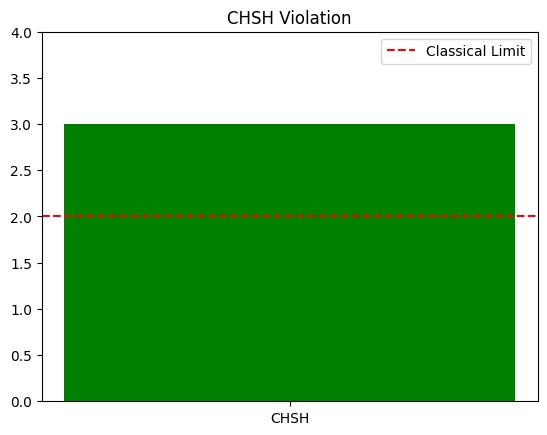

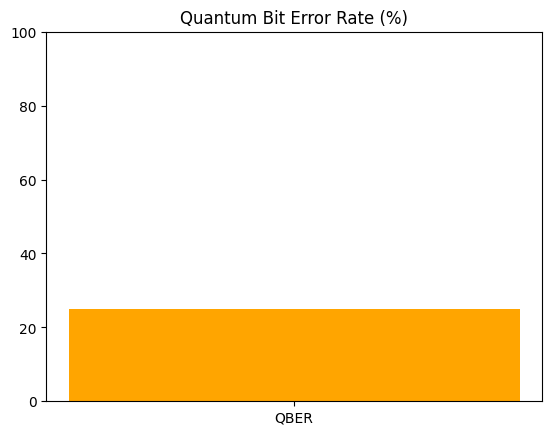

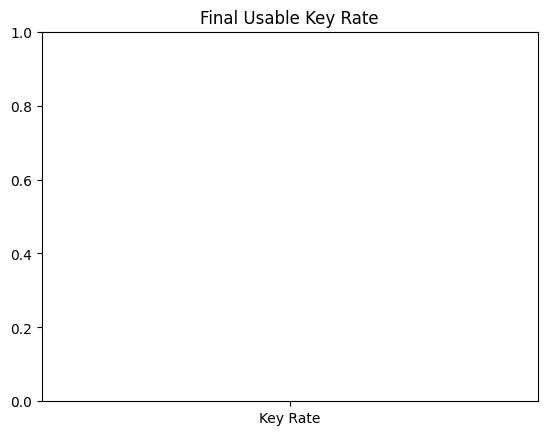

In [24]:
if __name__ == "__main__":
    rounds = int(input("Enter number of rounds (default 1000): ") or 1000)

    
    
    results = run_e91_simulation(rounds)
    #print(results)
    matched_bits = 0

    
        
    chsh_value = calculate_chsh(results)
    qber = calculate_qber(results, matched_bits)
    key_rate = calculate_key_rate(results, qber, rounds, matched_bits)
    secret_key = final_key(results)
    
    print(f"Final secret key : {secret_key}")
    print(f"\n✅ CHSH Value: {chsh_value:.3f} (Expected > 2)")
    print(f"✅ QBER: {qber * 100:.2f}%")
    print(f"✅ Final Key Rate: {key_rate:.3f}\n")
    
           
    try:
        plot_chsh(results)
        plot_qber(results)
        plot_key_rate(key_rate)
    except ModuleNotFoundError:
        print("❌ Visualization skipped: matplotlib is not installed.")
        print("To enable visualizations, run: pip install matplotlib")
    except Exception as e:
        print(f"❌ Visualization error: {e}")